In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas
import pandas as pd
import numpy as np
import talib
from sklearn.cluster import KMeans
from pandas_datareader import data as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import scipy.spatial.distance
from datetime import datetime as dt
from sklearn import mixture as mix
import statsmodels.api as sm
import seaborn as sb
sb.set_style('darkgrid')




pd.options.mode.chained_assignment = None  # default='warn'

In [28]:
#Then we fetch the OHLC data from Google and shift it by one day to train the algorithm only on the past data.
avg_err={}
avg_train_err={}

df= web.get_data_yahoo('SPY',start= '1977-01-01', end='2019-01-01')
df=df[['Open','High','Low','Close']]
#df['open']=df['Open'].shift(1)
#df['high']=df['High'].shift(1)
#df['low']=df['Low'].shift(1)
#df['close']=df['Close'].shift(1)

df['open']=df['Open']
df['high']=df['High']
df['low']=df['Low']
df['close']=df['Close']

df=df[['open','high','low','close']]
df.dropna(inplace=True)

                  open        high         low       close
Date                                                      
1993-01-29   43.968750   43.968750   43.750000   43.937500
1993-02-01   43.968750   44.250000   43.968750   44.250000
1993-02-02   44.218750   44.375000   44.125000   44.343750
1993-02-03   44.406250   44.843750   44.375000   44.812500
1993-02-04   44.968750   45.093750   44.468750   45.000000
...                ...         ...         ...         ...
2018-12-24  239.039993  240.839996  234.270004  234.339996
2018-12-26  235.970001  246.179993  233.759995  246.179993
2018-12-27  242.570007  248.289993  238.960007  248.070007
2018-12-28  249.580002  251.399994  246.449997  247.750000
2018-12-31  249.559998  250.190002  247.470001  249.919998

[6528 rows x 4 columns]


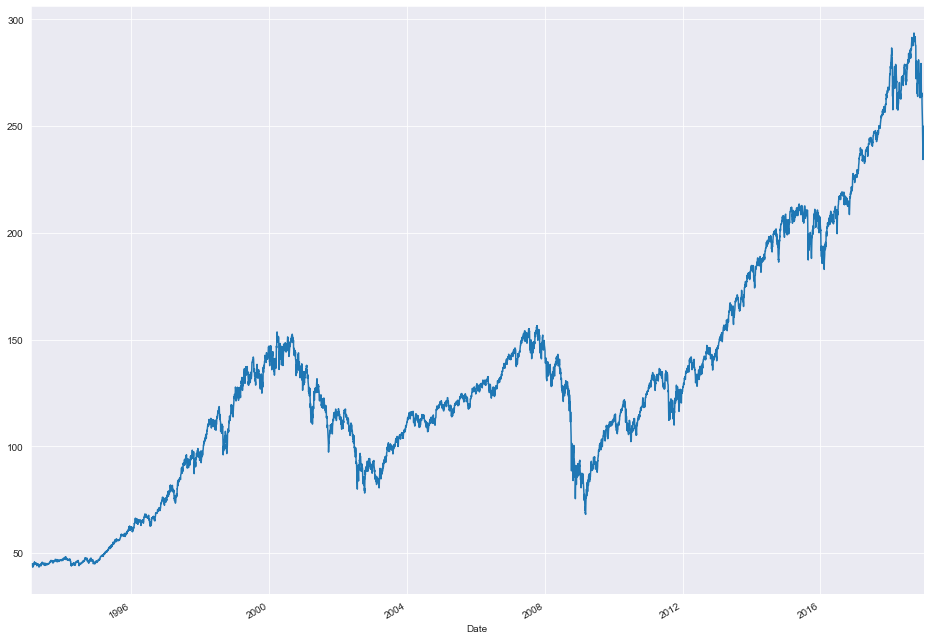

In [3]:
#Then drop all the NaN.

stock_data=df.dropna()
print(stock_data)

stock_data['close'].plot(figsize=(16, 12))



In [4]:

#The first obvious thing to note, aside from the two giant dips at the tail end corresponding to the market crashes in 2002 and 2008, is that the data is clearly non-stationary. This makes sense for market data as it tends to go up in the long run more than it goes down. This is a problem for time series analysis though as non-stationary data is hard to reason about. The first thing we can try is a first difference of the series. In other words, subtract the previous value t-1 from the current value t to get the difference d(t).



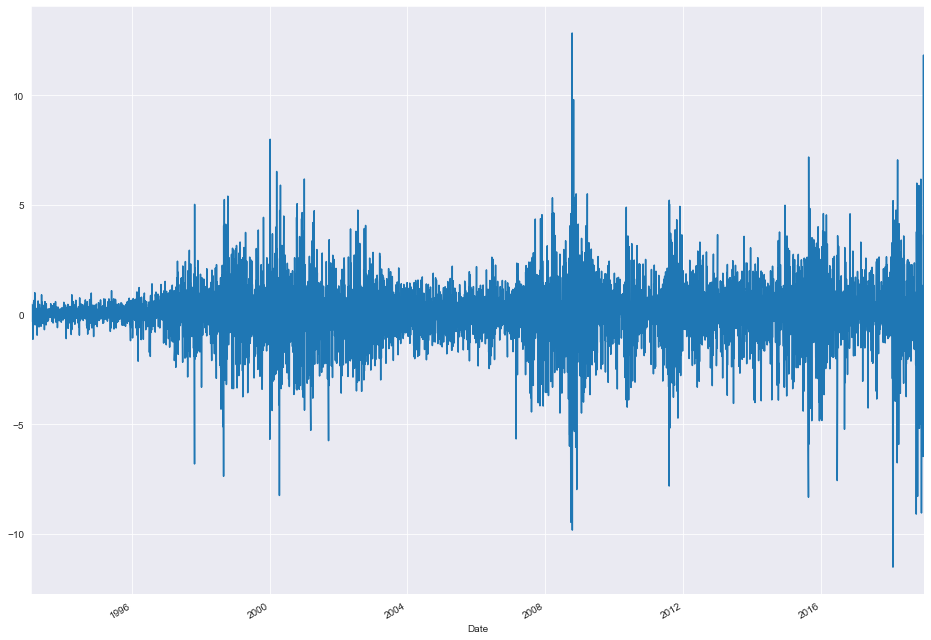

In [29]:
stock_data['First Difference'] = stock_data['close'] - stock_data['close'].shift()
stock_data['First Difference'].plot(figsize=(16, 12))

In [30]:
#The data no longer appears to be trending up over time and is instead centered around 0. There's another problem though. Look at the variance. It's very small early on and steadily increases over time. This is a sign that the data is not only non-stationary but also exponentially increasing. The magnitude of the day-to-day variations at present day completely dwarf the magnitude of the changes in 1950. To deal with this, we'll apply a log transform to the original series.

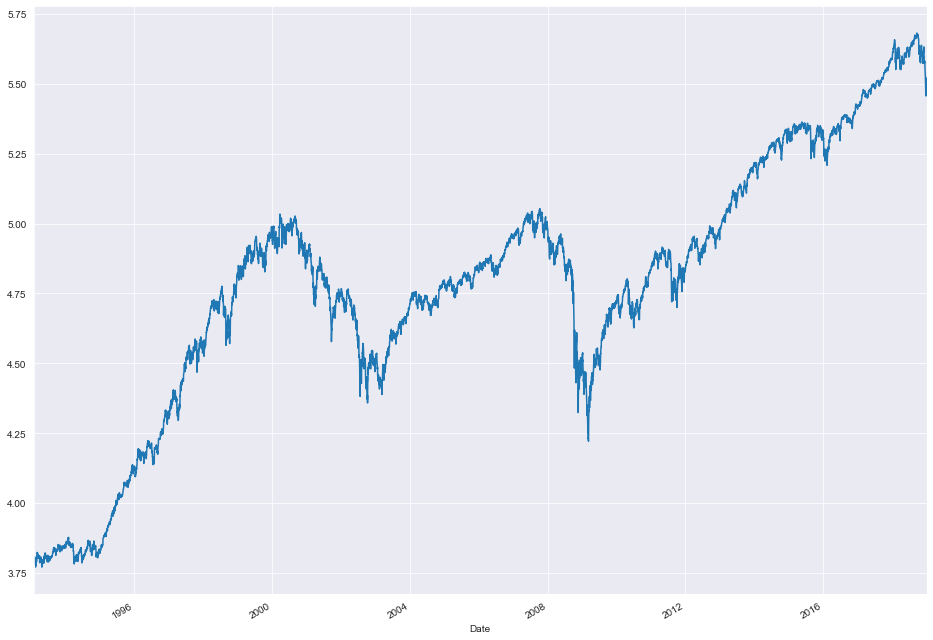

In [31]:
stock_data['Natural Log'] = stock_data['close'].apply(lambda x: np.log(x))
stock_data['Natural Log'].plot(figsize=(16, 12))

In [8]:
#So that gives us the original closing price with a log transform applied to "flatten" the data from an exponential curve to a linear curve. One way to visually see the effect that the log transform had is to analyze the variance over time. We can use a rolling variance statistic and compare both the original series and the logged series.

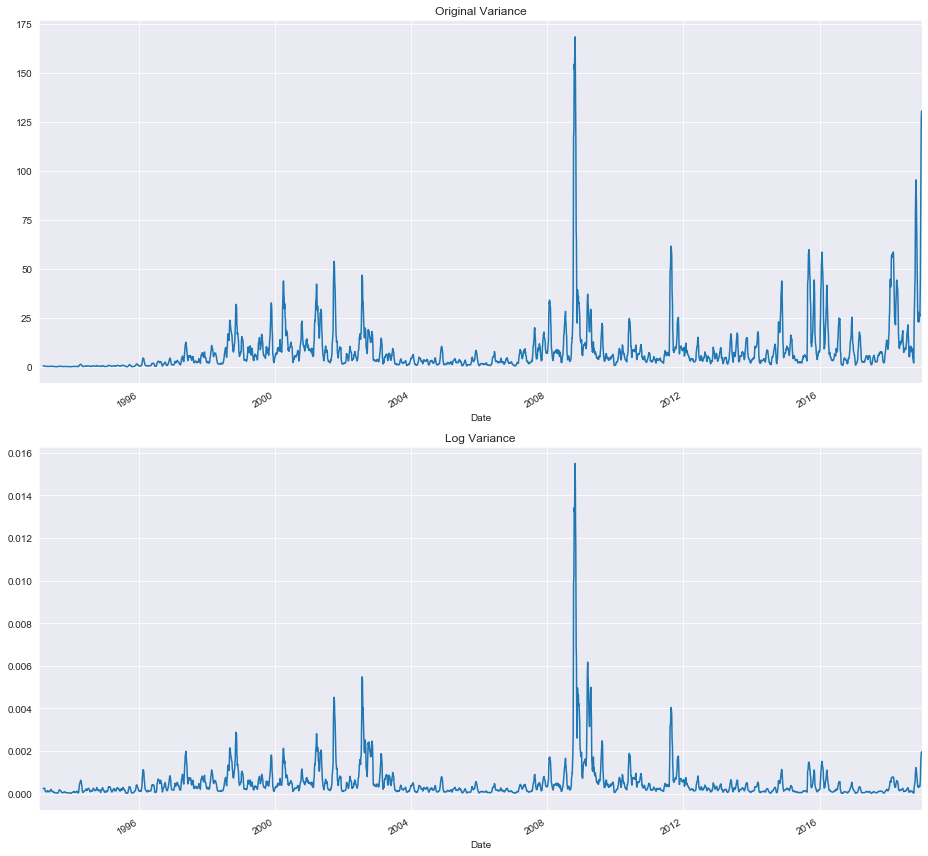

In [9]:
stock_data['Original Variance'] = stock_data['close'].rolling(30).var() 
stock_data['Log Variance'] =stock_data["Natural Log"].rolling(30).var()

#stock_data['Original Variance'] = pd.Rolling_var(stock_data['close'], 30, min_periods=None, freq=None, center=True)
#stock_data['Log Variance'] = pd.rolling_var(stock_data['Natural Log'], 30, min_periods=None, freq=None, center=True)

fig, ax = plt.subplots(2, 1, figsize=(13, 12))
stock_data['Original Variance'].plot(ax=ax[0], title='Original Variance')
stock_data['Log Variance'].plot(ax=ax[1], title='Log Variance')
fig.tight_layout()


In [10]:
#Observe that in the top graph, we can't even see any of the variations until the late 80s. In the bottom graph however it's a different story, changes in the value are clearly visible throughout the entire data set. From this view, it's clear that our transformation has made the variance relatively constant.

#Now we can see the earlier variations in the data set quite a bit better than before. We still need to take the first difference though so let's calculate that from the logged series.

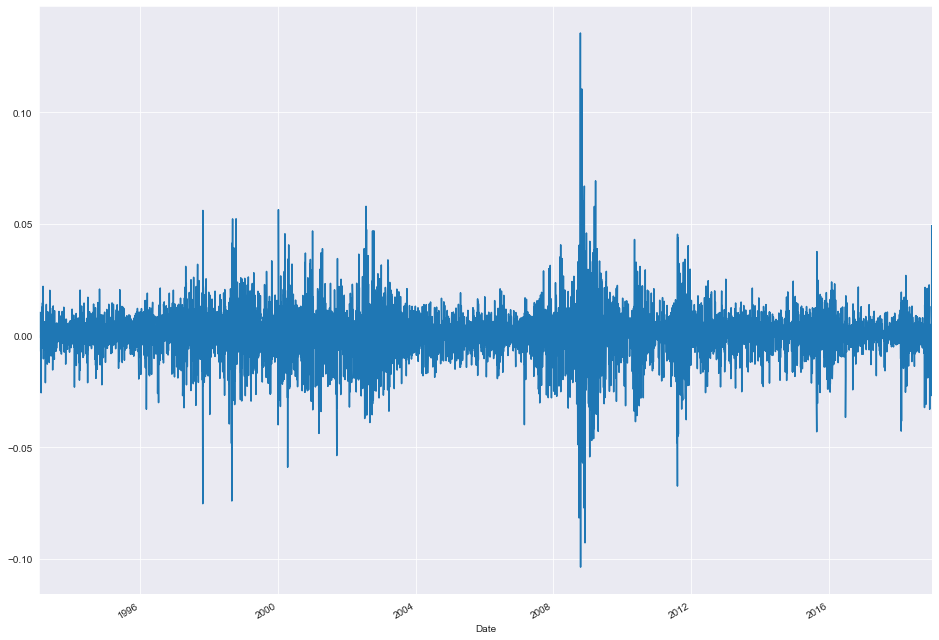

In [11]:
stock_data['Logged First Difference'] = stock_data['Natural Log'] - stock_data['Natural Log'].shift()
stock_data['Logged First Difference'].plot(figsize=(16, 12))

In [12]:
#Much better! We now have a stationary time series model of daily changes to the S&P 500 index. Now let's create some lag variables y(t-1), y(t-2) etc. and examine their relationship to y(t). We'll look at 1 and 2-day lags along with weekly and monthly lags to look for "seasonal" effects.

In [13]:
stock_data['Lag 1'] = stock_data['Logged First Difference'].shift()
stock_data['Lag 2'] = stock_data['Logged First Difference'].shift(2)
stock_data['Lag 5'] = stock_data['Logged First Difference'].shift(5)
stock_data['Lag 30'] = stock_data['Logged First Difference'].shift(30)

In [14]:
#One interesting visual way to evaluate the relationship between lagged variables is to do a scatter plot of the original variable vs. the lagged variable and see where the distribution lies. We can do this with a joint plot using the seaborn package.

C:\Users\Noah\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


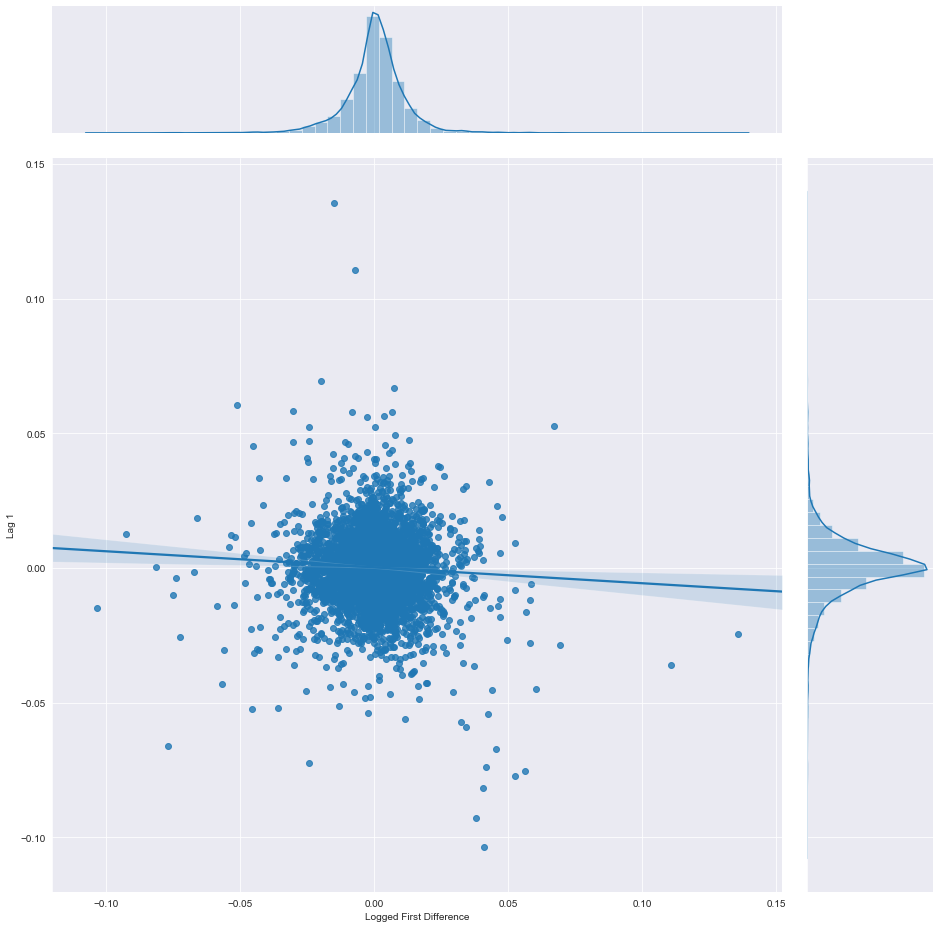

In [15]:
sb.jointplot('Logged First Difference', 'Lag 1', stock_data, kind='reg', size=13)

In [16]:
#Notice how tightly packed the mass is around 0. It also appears to be pretty evenly distributed - the marginal distributions on both axes are roughly normal. This seems to indicate that knowing the index value one day doesn't tell us much about what it will do the next day.

#It probably comes as no surprise that there's very little correlation between the change in value from one day to the next. Although I didn't plot them out here, the other lagged variables that we created above show similar results. There could be a relationship to other lag steps that we haven't tried, but it's impractical to test every possible lag value manually. Fortunately there is a class of functions that can systematically do this for us.

In [17]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

lag_correlations = acf(stock_data['Logged First Difference'].iloc[1:])
lag_partial_correlations = pacf(stock_data['Logged First Difference'].iloc[1:])

C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [18]:
#The auto-correlation function computes the correlation between a variable and itself at each lag step up to some limit (in this case 40). The partial auto-correlation function computes the correlation at each lag step that is NOT already explained by previous, lower-order lag steps. We can plot the results to see if there are any significant correlations.

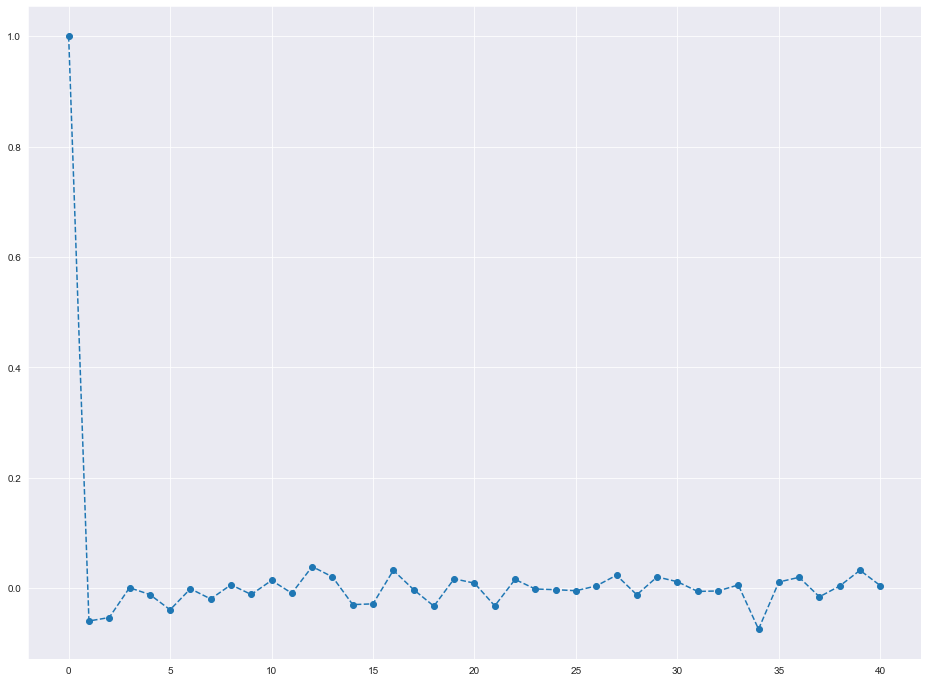

In [19]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(lag_correlations, marker='o', linestyle='--')

In [20]:
#The auto-correlation and partial-autocorrelation results are very close to each other (I only plotted the auto-correlation results above). What this shows is that there is no significant (> 0.2) correlation between the value at time t and at any time prior to t up to 40 steps behind. In order words, the series is a random walk.

#Another interesting technique we can try is a decomposition. This is a technique that attempts to break down a time series into trend, seasonal, and residual factors. Statsmodels comes with a decompose function out of the box.

<Figure size 432x288 with 0 Axes>

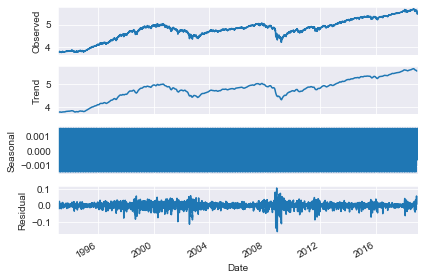

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(stock_data['Natural Log'], model='additive', freq=30)
fig = plt.figure()
fig = decomposition.plot()

In [22]:
residual = decomposition.resid
seasonal = decomposition.seasonal 
trend = decomposition.trend

In [23]:
stock_data['trend']=decomposition.trend

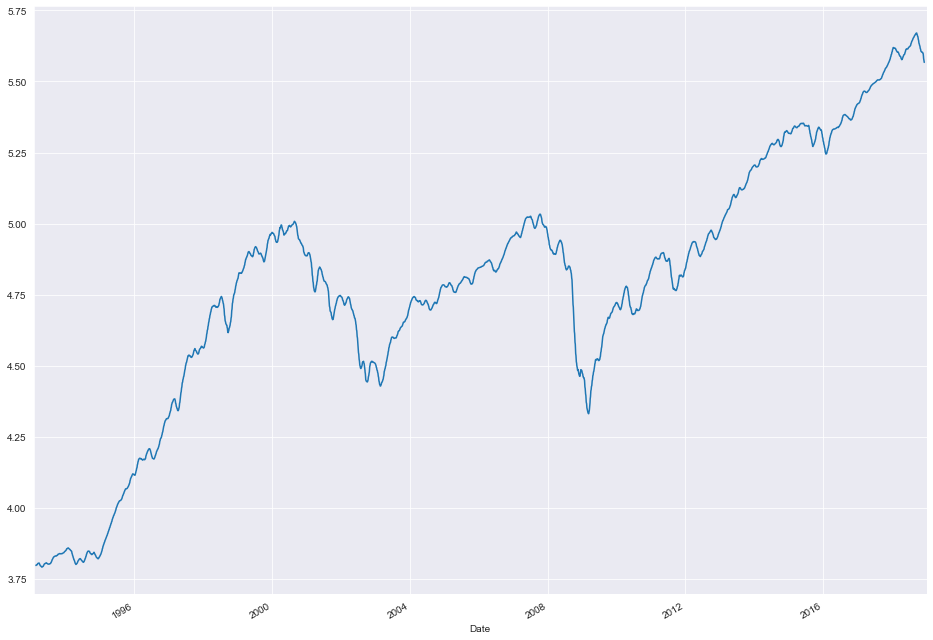

In [24]:
stock_data['trend'].plot(figsize=(16, 12))

In [25]:

#Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Time-series forecasting is widely used for non-stationary data. Non-stationary data are called the data whose statistical properties e.g. the mean and standard deviation are not constant over time but instead, these metrics vary over time.
#These non-stationary input data (used as input to these models) are usually called time-series. Some examples of time-series include the temperature values over time, stock price over time, price of a house over time etc. So, the input is a signal (time-series) that is defined by observations taken sequentially in time.

In [26]:
#The next step is to split the data into training and test sets to avoid overfitting and to be able to investigate the generalization ability of our model. To learn more about overfitting read this article:
#The target value to be predicted is going to be the “Close” stock price value.

           Date        open        high         low       close
0    1993-01-29   43.968750   43.968750   43.750000   43.937500
1    1993-02-01   43.968750   44.250000   43.968750   44.250000
2    1993-02-02   44.218750   44.375000   44.125000   44.343750
3    1993-02-03   44.406250   44.843750   44.375000   44.812500
4    1993-02-04   44.968750   45.093750   44.468750   45.000000
...         ...         ...         ...         ...         ...
6523 2018-12-24  239.039993  240.839996  234.270004  234.339996
6524 2018-12-26  235.970001  246.179993  233.759995  246.179993
6525 2018-12-27  242.570007  248.289993  238.960007  248.070007
6526 2018-12-28  249.580002  251.399994  246.449997  247.750000
6527 2018-12-31  249.559998  250.190002  247.470001  249.919998

[6528 rows x 5 columns]


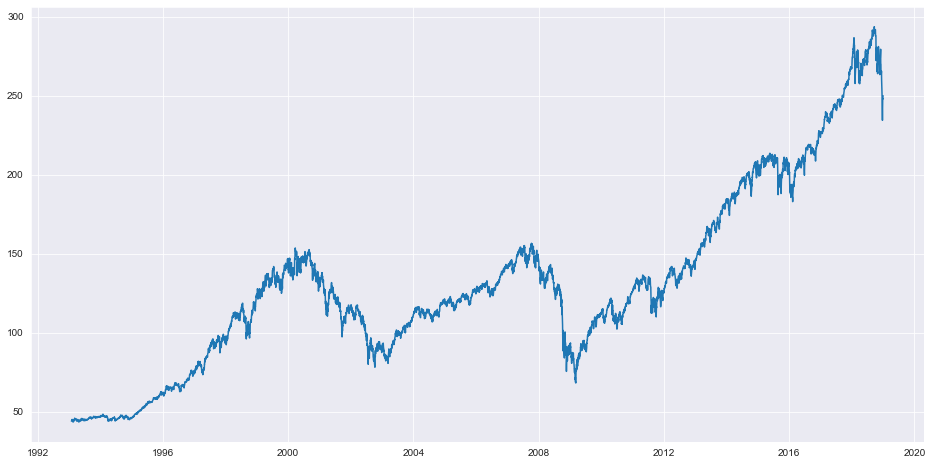

In [27]:
df.reset_index(level=0, inplace=True)

print(df)

#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Close Price history')
